# This notebook is for the initial creation and preprocessing of the data. The raw data is taken from the real simulation, in this case.

In [1]:
import numpy as np
import pandas as pd
import os
from jupyterthemes import jtplot
import datetime as dt
import seaborn as sns
import json

import matplotlib.pyplot as plt
%matplotlib inline
jtplot.style(theme='solarizedd')
plt.rcParams['figure.figsize'] = (20.0, 10.0)

ROOT_DIR = '/home/miguel/github_repos/python-ds'
DATA_DIR = os.path.join(ROOT_DIR, 'data')
DATA_RAW = os.path.join(DATA_DIR, 'raw')
DATA_INTERIM = os.path.join(DATA_DIR, 'interim')
DATA_EXTERNAL = os.path.join(DATA_DIR, 'external')
DATA_PROCESSED = os.path.join(DATA_DIR, 'processed')

DATA = os.path.join(DATA_RAW, 'raw_data.txt')
PATHS_JSON = os.path.join(DATA_RAW, 'trayectosporlinea.json')

SRC_DIR = os.path.join(ROOT_DIR, 'src')

import sys
sys.path.append(SRC_DIR)

## 1. Getting a DataFrame

In [2]:
def parse_time(timestr):
    """ Converts a time string to datetime. Ignores the sub-second part. """
    return dt.datetime.strptime(timestr.split('.')[0], '%Y-%m-%dT%H:%M:%S')

In [3]:
def parse_line(line):
    """ Parses all the records for one timestamp. """
    record = json.loads(line.replace('\n',''))['data'][0]
    
    # Regular data
    data = dict()
    data['id'] = record['id']
    data['timestamp'] = parse_time(record['timestamp']['value'])
    data['codigoBus'] = record['codigoBus']['value']
    data['linea'] = record['linea']['value']
    data['x'] = record['location']['value']['coordinates'][0]
    data['y'] = record['location']['value']['coordinates'][1]
    data['uid'] = str(data['linea']) + '_' + str(data['codigoBus'])
    
    # GeoJson for fancy maps
    geographic = dict()
    geographic['timestamp'] = data['timestamp']
    geographic['linea'] = data['linea']
    geographic['codigoBus'] = data['codigoBus']
    geographic['geojson'] = record['location']
    
    return data, geographic

In [4]:
def parse_file(filepath, parse_line=parse_line):
    """ Returns a DataFrame with all the relevant data from a txt input file. """
    with open(filepath, 'r') as file:
        lines = file.readlines()
    data = list()
    geographic = list()
    for line in lines:
        data_line, geographic_line = parse_line(line)
        data.append(data_line)
        geographic.append(geographic_line)
    return pd.DataFrame(data), pd.DataFrame(geographic)

In [5]:
def parse_data(root_dir=ROOT_DIR):
    """ 
    Parse the raw data to a DataFrame.
    """
    data_dir = os.path.join(root_dir, 'data')
    data_raw = os.path.join(data_dir, 'raw')
    raw_data_path = os.path.join(data_raw, 'raw_data.txt')
    return parse_file(raw_data_path)

In [6]:
data, geographic = parse_data()
print(data.shape)
data.head()

(276222, 7)


codigoBus   id linea           timestamp       uid          x          y
0        241  241  7517 2018-10-02 14:04:52  7517_241 -56.161850 -34.927967
1        710  710  7921 2018-10-02 14:04:52  7921_710 -56.111473 -34.870167
2        961  961   343 2018-10-02 14:04:52   343_961 -56.129692 -34.852690
3         78   78  2454 2018-10-02 14:04:52   2454_78 -56.022778 -34.871360
4         15   15   217 2018-10-02 14:04:52    217_15 -56.185750 -34.881184

In [7]:
geographic.head()

codigoBus                                            geojson linea  \
0        241  {'type': 'geo:json', 'value': {'type': 'Point'...  7517   
1        710  {'type': 'geo:json', 'value': {'type': 'Point'...  7921   
2        961  {'type': 'geo:json', 'value': {'type': 'Point'...   343   
3         78  {'type': 'geo:json', 'value': {'type': 'Point'...  2454   
4         15  {'type': 'geo:json', 'value': {'type': 'Point'...   217   

            timestamp  
0 2018-10-02 14:04:52  
1 2018-10-02 14:04:52  
2 2018-10-02 14:04:52  
3 2018-10-02 14:04:52  
4 2018-10-02 14:04:52

In [8]:
geographic.to_pickle(os.path.join(DATA_INTERIM, 'geographic.pkl'))

In [8]:
(data.id.astype(int) != data.codigoBus).sum()

0

Then those columns are the same, in fact.

In [9]:
data = data.drop('id', axis=1)

In [10]:
data.head()

codigoBus linea           timestamp      uid          x          y
0        241  7517 2018-10-02 14:04:52  7517241 -56.161850 -34.927967
1        710  7921 2018-10-02 14:04:52  7921710 -56.111473 -34.870167
2        961   343 2018-10-02 14:04:52   343961 -56.129692 -34.852690
3         78  2454 2018-10-02 14:04:52   245478 -56.022778 -34.871360
4         15   217 2018-10-02 14:04:52    21715 -56.185750 -34.881184

In [11]:
data.duplicated().sum()

94499

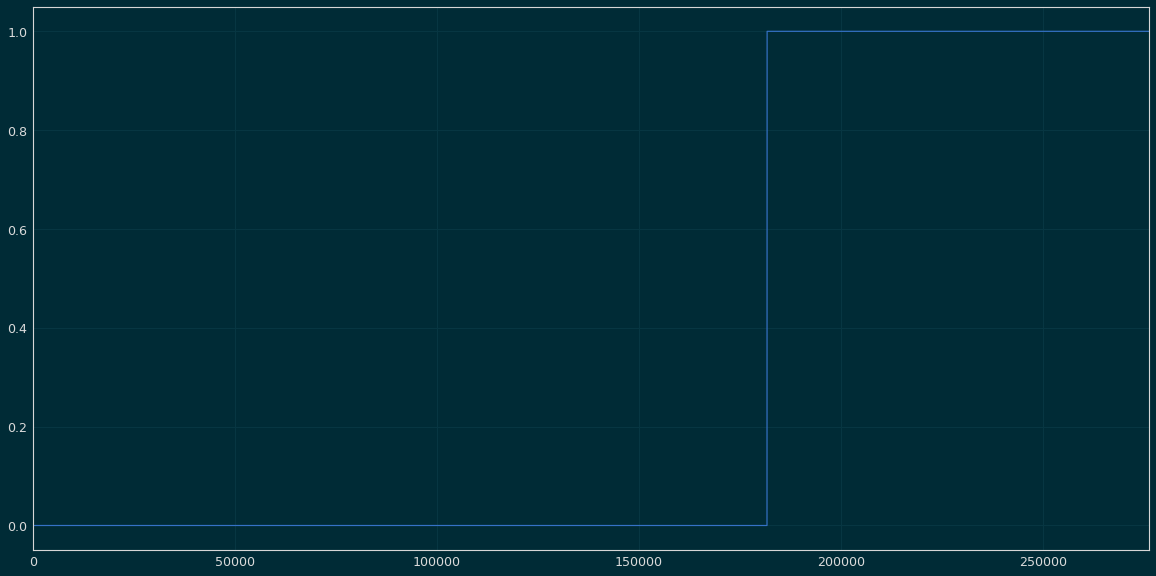

In [12]:
data.duplicated().plot()

Excelent! The duplicated ones are all in the end, as expected

In [13]:
data = data.drop_duplicates()
print(data.shape)
data.head()

(181723, 6)


codigoBus linea           timestamp      uid          x          y
0        241  7517 2018-10-02 14:04:52  7517241 -56.161850 -34.927967
1        710  7921 2018-10-02 14:04:52  7921710 -56.111473 -34.870167
2        961   343 2018-10-02 14:04:52   343961 -56.129692 -34.852690
3         78  2454 2018-10-02 14:04:52   245478 -56.022778 -34.871360
4         15   217 2018-10-02 14:04:52    21715 -56.185750 -34.881184

In [14]:
data.timestamp.apply(lambda x: x.date()).unique()

array([datetime.date(2018, 10, 2)], dtype=object)

### Let's compare that with the txt data.

In [15]:
txt_data = pd.read_pickle(os.path.join(DATA_INTERIM, 'data.pkl'))

In [16]:
print(txt_data.shape)
txt_data.head()

(250039, 5)


codigoBus linea           timestamp          x          y
0        241  7517 2018-10-02 14:04:37 -56.161850 -34.927967
1        710  7921 2018-10-02 14:04:37 -56.111443 -34.870167
2        961   343 2018-10-02 14:04:37 -56.129030 -34.851887
3         78  2454 2018-10-02 14:04:37 -56.022057 -34.869860
4         15   217 2018-10-02 14:04:37 -56.183617 -34.882000

In [17]:
data_date = data.timestamp.apply(lambda x: x.date()).unique()[0]
data_date

datetime.date(2018, 10, 2)

In [18]:
day1_txt = txt_data[txt_data.timestamp.apply(lambda x: x.date()) == data_date]
day1_txt.shape

(181914, 5)

In [19]:
day1_txt = day1_txt.set_index(['linea', 'codigoBus', 'timestamp'])
day1_txt = day1_txt.rename(
    columns={col: col + '_txt' for col in day1_txt.columns})
data = data.set_index(['linea', 'codigoBus', 'timestamp'])

In [20]:
joined = day1_txt.join(data)
joined.head()

x_txt      y_txt      uid          x  \
linea codigoBus timestamp                                                       
1476  262       2018-10-02 17:12:57 -56.200943 -34.906445  1476262 -56.200943   
                2018-10-02 17:13:12 -56.200806 -34.906500  1476262 -56.200806   
                2018-10-02 17:13:27 -56.200890 -34.906580  1476262 -56.200890   
                2018-10-02 17:13:42 -56.200890 -34.907030  1476262 -56.200890   
                2018-10-02 17:13:57 -56.200695 -34.906803  1476262 -56.200695   

                                             y  
linea codigoBus timestamp                       
1476  262       2018-10-02 17:12:57 -34.906445  
                2018-10-02 17:13:12 -34.906500  
                2018-10-02 17:13:27 -34.906580  
                2018-10-02 17:13:42 -34.907030  
                2018-10-02 17:13:57 -34.906803

In [21]:
joined.isnull().sum()

x_txt      0
y_txt      0
uid      192
x        192
y        192
dtype: int64

That shows that 192 samples were not collected in the simulation. Which ones?

In [22]:
192 / joined.shape[0]

0.0010554379792760355

Are the missing values concentrated in any specific timestamp?

In [23]:
missing = joined.isnull().apply(lambda x: x.any(), axis=1)

In [24]:
tss = joined[missing].reset_index('timestamp').timestamp
tss.shape

(192,)

In [25]:
tss.unique()

array(['2018-10-02T14:04:37.000000000'], dtype='datetime64[ns]')

That is, one entire timestamp missing. Reasonable.

In [26]:
filtered = joined.dropna()

In [27]:
different = (filtered[['x_txt', 'y_txt']].rename(
    columns={'x_txt':'x', 'y_txt':'y'}) != filtered[['x', 'y']])
different.sum()

x    1
y    1
dtype: int64

In [28]:
weird = filtered[different.any(axis=1)]
weird

x_txt      y_txt      uid         x  \
linea codigoBus timestamp                                                      
7517  241       2018-10-02 14:04:52 -56.161865 -34.927933  7517241 -56.16185   

                                             y  
linea codigoBus timestamp                       
7517  241       2018-10-02 14:04:52 -34.927967

In [29]:
weird.x_txt - weird.x

linea  codigoBus  timestamp          
7517   241        2018-10-02 14:04:52   -0.000015
dtype: float64

In [30]:
weird.y_txt - weird.y

linea  codigoBus  timestamp          
7517   241        2018-10-02 14:04:52    0.000034
dtype: float64

In [31]:
weird[['x_txt', 'y_txt']].values[0]

array([-56.161865, -34.927933])

In [32]:
np.linalg.norm(weird[['x_txt', 'y_txt']].values[0] - weird[['x', 'y']].values[0])

3.7161808350650311e-05

In [33]:
100000 * 3.7e-5

3.6999999999999997

Let's say that's an error of about 5 meters. Irrelevant.

In conclusion: the simulated data comes from "historia-buses.txt".

In [ ]:
data = data.reset_index()

### Let's save it

In [34]:
data.to_pickle(os.path.join(DATA_INTERIM, 'sim_data.pkl'))
data.to_csv(os.path.join(DATA_INTERIM, 'sim_data.csv'))

In [37]:
data.groupby('timestamp').apply(lambda x: x[['linea','codigoBus']].duplicated().sum()).describe()

count    983.000000
mean       0.001017
std        0.031895
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.000000
dtype: float64

In [38]:
data.groupby('timestamp').apply(
    lambda x: x[['linea','codigoBus']].duplicated().sum()).sort_values(ascending=False)[:5]

timestamp
2018-10-02 14:04:52    1
2018-10-02 15:28:54    0
2018-10-02 15:28:24    0
2018-10-02 15:28:09    0
2018-10-02 15:27:54    0
dtype: int64

In [39]:
t_data = data[data.timestamp == '2018-10-02 14:04:52']
t_data[t_data[['linea','codigoBus']].duplicated()]

linea  codigoBus           timestamp      uid          x          y
192  7517        241 2018-10-02 14:04:52  7517241 -56.161865 -34.927933

In [40]:
t_data.set_index(['linea','codigoBus']).loc[('7517', 241), :]

/home/miguel/anaconda3/envs/desafiotea/lib/python3.6/site-packages/pandas/core/indexing.py:1325: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)


timestamp      uid          x          y
linea codigoBus                                                   
7517  241       2018-10-02 14:04:52  7517241 -56.161850 -34.927967
      241       2018-10-02 14:04:52  7517241 -56.161865 -34.927933

Clearly the duplicated one is the one that also is different with the txt data.

### Let's save the data